# Identification of credit card fraud cases through supervised and unsupervised learning models
## Nurlybay Bexultan AAI-2502

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    f1_score, precision_score, recall_score, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, classification_report
)
import umap.umap_ as umap

## 1. Data Preparation

### 1.1. Load dataset

In [2]:
df = pd.read_csv("creditcard.csv")
print("Shape:", df.shape)
df.head()

Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.2. Exploration

In [3]:
print("\nClass distribution:")
print(df['Class'].value_counts())

print("\nPercentage of frauds:")
print(df['Class'].value_counts(normalize=True)*100)

print("\nMissing values per column:")
print(df.isnull().sum())


Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Percentage of frauds:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


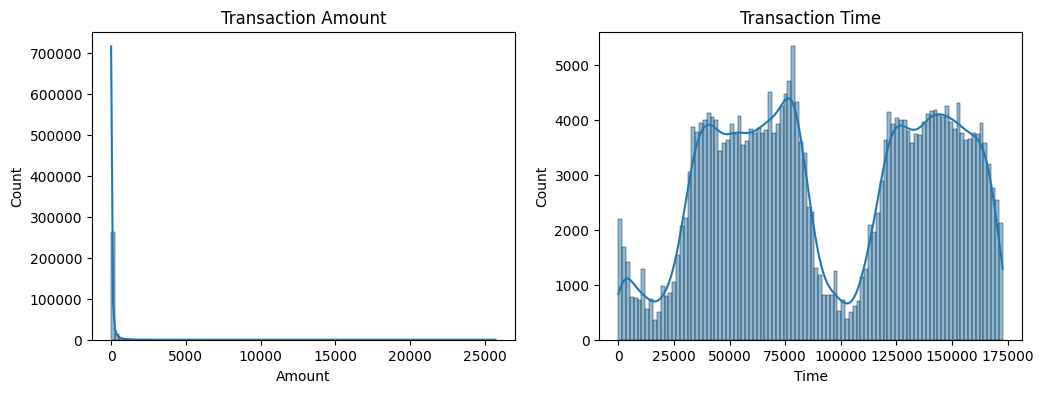

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df['Amount'], bins=100, ax=ax[0], kde=True)
ax[0].set_title("Transaction Amount")

sns.histplot(df['Time'], bins=100, ax=ax[1], kde=True)
ax[1].set_title("Transaction Time")

plt.show()

### 1.3. Train/Test Split

In [6]:
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True) * 100)

Train shape: (227845, 30)
Test shape: (56962, 30)

Class distribution in training set:
Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64

Class distribution in test set:
Class
0    99.827955
1     0.172045
Name: proportion, dtype: float64


### 1.4. Scale numerical features

In [7]:
scale_features = ['Amount', 'Time']

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', RobustScaler(), scale_features)
    ],
    remainder='passthrough'  # V1..V28 remain unchanged
)
X_train_scaled = preprocessor.fit_transform(X_train)

## 2. Feature Selection

In [8]:
k = X_train.shape[1]

selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train, y_train)

selected = X_train.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]

selectk_results = pd.DataFrame({
    "Feature": selected,
    "Score": scores
}).sort_values(by="Score", ascending=False)

print(f"\n=== Top {k} Features (SelectKBest) ===")
print(selectk_results)


=== Top 30 Features (SelectKBest) ===
   Feature         Score
17     V17  26344.857930
14     V14  22708.416660
12     V12  16517.397225
10     V10  11356.633951
3       V3   8923.391931
16     V16   8893.808593
7       V7   8181.662227
11     V11   5513.355042
4       V4   4230.410380
18     V18   2725.936029
1       V1   2303.364607
9       V9   2220.679238
5       V5   2012.831298
2       V2   1885.090430
6       V6    428.650897
21     V21    288.934519
19     V19    239.131583
8       V8     96.279021
20     V20     85.654286
27     V27     58.594373
0     Time     25.427481
28     V28     21.927431
24     V24     12.758531
29  Amount      8.789644
13     V13      7.826090
15     V15      7.416895
23     V23      3.959268
26     V26      3.866578
22     V22      1.950294
25     V25      0.596135


In [9]:
rfe_selector = RFE(
    estimator=LogisticRegression(max_iter=1000),
    n_features_to_select=10
)

rfe_selector.fit(X_train_scaled, y_train)

selected_rfe = X_train.columns[rfe_selector.get_support()]

print("\n=== RFE Selected Features (10) ===")
print(selected_rfe)


=== RFE Selected Features (10) ===
Index(['V5', 'V9', 'V10', 'V11', 'V14', 'V15', 'V17', 'V22', 'V23', 'V28'], dtype='object')


In [10]:
for n in [5, 10, 15]:
    pca = PCA(n_components=n)
    pca.fit(X_train_scaled)

    explained = pca.explained_variance_ratio_.sum()

    print(f"\n=== PCA with {n} components ===")
    print(f"Explained variance: {explained:.4f}")


=== PCA with 5 components ===
Explained variance: 0.5674

=== PCA with 10 components ===
Explained variance: 0.7363

=== PCA with 15 components ===
Explained variance: 0.8481


## 3. Handling Imbalanced Data

In [11]:
base_clf = LogisticRegression(max_iter=500)
smote = SMOTE(random_state=42)

pipe = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', smote),
    ('clf', base_clf)
])


param_grid = {
    'smote__k_neighbors': [1, 3, 5, 7],
    'smote__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 'auto']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best SMOTE parameters:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best SMOTE parameters: {'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.1}
Best CV AUC: 0.9763492457991778


In [ ]:
X_train_prep = preprocessor.fit_transform(X_train)

best_k = grid.best_params_['smote__k_neighbors']
best_samp = grid.best_params_['smote__sampling_strategy']
smote_best = SMOTE(
    k_neighbors=best_k,
    sampling_strategy=best_samp,
    random_state=42
)

X_smote, y_smote = smote_best.fit_resample(X_train_prep, y_train)

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

umap_model.fit(X_train_prep)
X_before_emb = umap_model.transform(X_train_prep)
X_after_emb = umap_model.transform(X_smote)

idx_b = np.random.choice(len(X_before_emb), 8000, replace=False)
idx_a = np.random.choice(len(X_after_emb), 8000, replace=False)

fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].scatter(
    X_before_emb[idx_b,0], X_before_emb[idx_b,1],
    c=y_train.iloc[idx_b], cmap='coolwarm', s=5
)
ax[0].set_title("BEFORE SMOTE")

ax[1].scatter(
    X_after_emb[idx_a,0], X_after_emb[idx_a,1],
    c=y_smote[idx_a], cmap='coolwarm', s=5
)
ax[1].set_title("AFTER SMOTE")

plt.show()

## 4. Supervised Learning Model: XGBoost

In [12]:
best_k = grid.best_params_['smote__k_neighbors']
best_samp = grid.best_params_['smote__sampling_strategy']

smote_best = SMOTE(
    k_neighbors=best_k,
    sampling_strategy=best_samp,
    random_state=42
)

xgb = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', smote_best),
    ('clf', xgb)
])

param_dist = {
    'clf__n_estimators': [200, 400, 600],
    'clf__max_depth': [3, 5, 7, 9],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__gamma': [0, 0.1, 0.25, 0.5],
    'clf__reg_alpha': [0, 0.1, 1, 5],
    'clf__reg_lambda': [1, 5, 10]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rsearch = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=25,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

rsearch.fit(X_train, y_train)
best_xgb = rsearch.best_estimator_

print("\nBest XGBoost parameters:")
print(rsearch.best_params_)

print("\nBest CV ROC-AUC:", rsearch.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:47:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGBoost parameters:
{'clf__subsample': 0.8, 'clf__reg_lambda': 1, 'clf__reg_alpha': 1, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__gamma': 0.5, 'clf__colsample_bytree': 0.6}

Best CV ROC-AUC: 0.9854122325938629


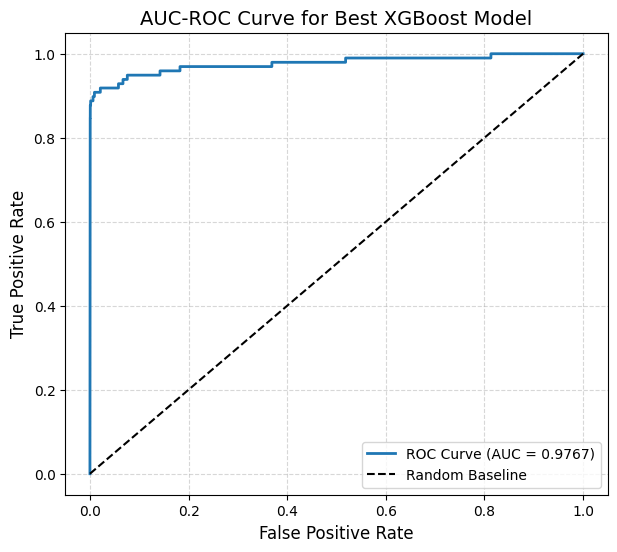

In [13]:
y_proba = best_xgb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_value = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_value:.4f})', linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Random Baseline')

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("AUC-ROC Curve for Best XGBoost Model", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 5. Threshold Optimization

In [14]:
thresholds = np.linspace(0.01, 0.99, 99)

best_f1 = best_f1_t = 0
best_recall = best_recall_t = 0
best_precision = best_precision_t = 0

for t in thresholds:
    preds = (y_proba >= t).astype(int)

    f1 = f1_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    prec = precision_score(y_test, preds, zero_division=0)

    if f1 > best_f1:
        best_f1, best_f1_t = f1, t
    if rec > best_recall:
        best_recall, best_recall_t = rec, t
    if prec > best_precision:
        best_precision, best_precision_t = prec, t

print("Best F1 threshold:", best_f1_t, "F1 =", best_f1)
print("Best Recall threshold:", best_recall_t, "Recall =", best_recall)
print("Best Precision threshold:", best_precision_t, "Precision =", best_precision)

Best F1 threshold: 0.75 F1 = 0.7979274611398963
Best Recall threshold: 0.01 Recall = 1.0
Best Precision threshold: 0.8200000000000001 Precision = 0.8488372093023255


In [15]:
y_pred_default = (y_proba >= 0.5).astype(int)

best_thresh = best_f1_t   # or best_recall_t or pr_best_t
y_pred_best = (y_proba >= best_thresh).astype(int)

print("=======================================")
print("  CLASSIFICATION REPORT (Threshold 0.5)")
print("=======================================")
print(classification_report(y_test, y_pred_default, digits=4))

print("\n=======================================")
print(f"  CLASSIFICATION REPORT (Best threshold = {best_thresh:.4f})")
print("=======================================")
print(classification_report(y_test, y_pred_best, digits=4))

  CLASSIFICATION REPORT (Threshold 0.5)
              precision    recall  f1-score   support

           0     0.9998    0.9994    0.9996     56864
           1     0.7000    0.8571    0.7706        98

    accuracy                         0.9991     56962
   macro avg     0.8499    0.9283    0.8851     56962
weighted avg     0.9992    0.9991    0.9992     56962


  CLASSIFICATION REPORT (Best threshold = 0.7500)
              precision    recall  f1-score   support

           0     0.9996    0.9997    0.9997     56864
           1     0.8105    0.7857    0.7979        98

    accuracy                         0.9993     56962
   macro avg     0.9051    0.8927    0.8988     56962
weighted avg     0.9993    0.9993    0.9993     56962



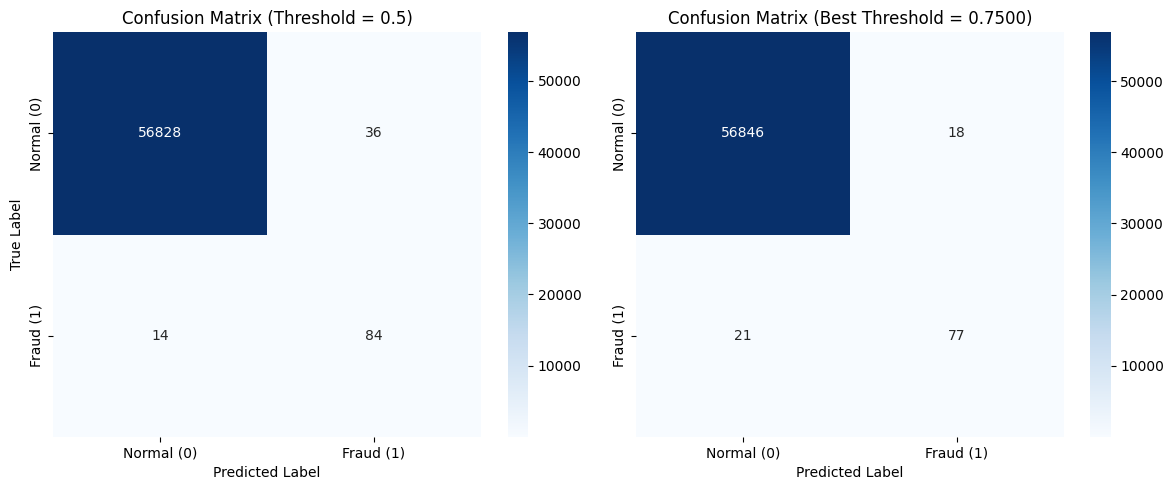

In [16]:
cm_default = confusion_matrix(y_test, y_pred_default)
cm_best = confusion_matrix(y_test, y_pred_best)

labels = ["Normal (0)", "Fraud (1)"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Threshold 0.5 ---
sns.heatmap(
    cm_default, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels, ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Threshold = 0.5)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# --- Best Threshold ---
sns.heatmap(
    cm_best, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels, ax=axes[1]
)
axes[1].set_title(f"Confusion Matrix (Best Threshold = {best_thresh:.4f})")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

## 6. Unsupervised Learning Model: Isolation Forest

In [17]:
X_train_if = preprocessor.fit_transform(X_train)
X_test_if = preprocessor.transform(X_test)

n_estimators_list = [100, 200, 300, 400]
max_samples_list = ["auto", 10000, 20000, 50000]
contamination_list = [0.001, 0.002, 0.005, 0.01]
max_features_list = [0.5, 0.75, 1.0]

best_auc = -1
best_iso_params = None
best_iso = None

for n_est in n_estimators_list:
    for max_samp in max_samples_list:
        for cont in contamination_list:
            for max_feat in max_features_list:

                model = IsolationForest(
                    n_estimators=n_est,
                    max_samples=max_samp,
                    contamination=cont,
                    max_features=max_feat,
                    random_state=42,
                    n_jobs=-1
                )

                model.fit(X_train_if)

                preds_raw = model.predict(X_test_if)
                preds_binary = np.where(preds_raw == -1, 1, 0)

                auc = roc_auc_score(y_test, preds_binary)

                if auc > best_auc:
                    best_auc = auc
                    best_iso_params = {
                        "n_estimators": n_est,
                        "max_samples": max_samp,
                        "contamination": cont,
                        "max_features": max_feat
                    }
                    best_iso = model

print("Best parameters:", best_iso_params)
print("Best AUC:", best_auc)

Best parameters: {'n_estimators': 100, 'max_samples': 50000, 'contamination': 0.01, 'max_features': 0.5}
Best AUC: 0.8729435358836838


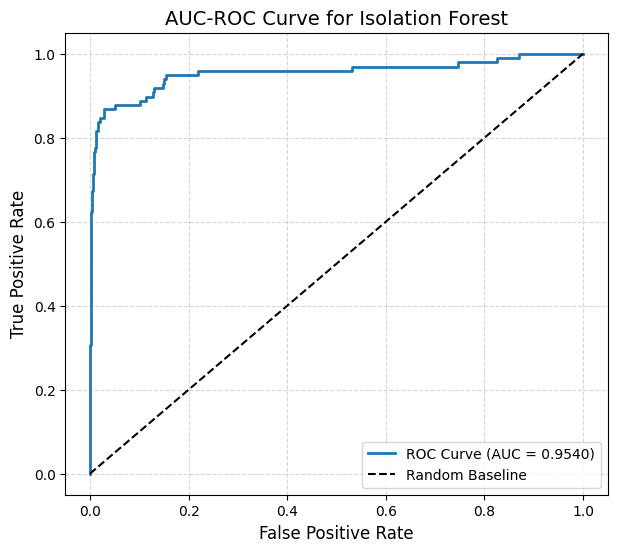

In [20]:
scores = best_iso.decision_function(X_test_if)
y_proba = -scores

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_value = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, linewidth=2, label=f"ROC Curve (AUC = {auc_value:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Baseline")

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("AUC-ROC Curve for Isolation Forest", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## 7. Comparison

In [22]:
xgb_proba = best_xgb.predict_proba(X_test)[:, 1]
xgb_pred = (xgb_proba >= 0.5).astype(int)

xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_proba)

iso_scores = best_iso.decision_function(X_test_if)
iso_proba = -iso_scores
iso_pred = np.where(best_iso.predict(X_test_if) == -1, 1, 0)

iso_precision = precision_score(y_test, iso_pred)
iso_recall = recall_score(y_test, iso_pred)
iso_f1 = f1_score(y_test, iso_pred)
iso_auc = roc_auc_score(y_test, iso_proba)

results = pd.DataFrame({
    "Model": ["XGBoost", "Isolation Forest"],
    "Precision": [xgb_precision, iso_precision],
    "Recall": [xgb_recall, iso_recall],
    "F1-score": [xgb_f1, iso_f1],
    "AUC": [xgb_auc, iso_auc]
})

results.set_index("Model", inplace=True)
results

,Precision,Recall,F1-score,AUC
Model,,,,
XGBoost,0.700000,0.857143,0.770642,0.976735
Isolation Forest,0.123746,0.755102,0.212644,0.954034


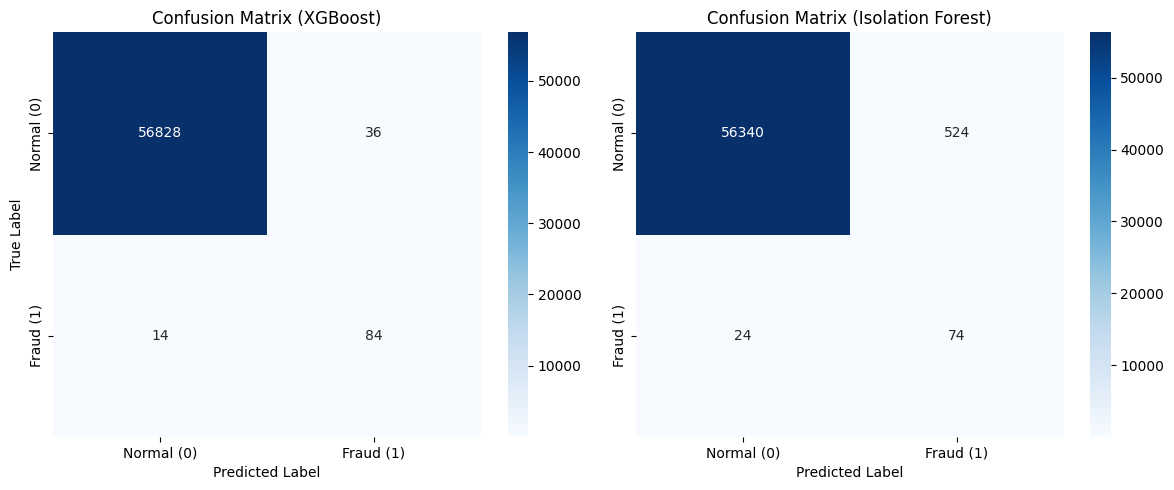

In [24]:
cm_xgb = confusion_matrix(y_test, xgb_pred)
cm_iso = confusion_matrix(y_test, iso_pred)

labels = ["Normal (0)", "Fraud (1)"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- XGBoost ---
sns.heatmap(
    cm_xgb, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels, ax=axes[0]
)
axes[0].set_title("Confusion Matrix (XGBoost)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# --- Isolation Forest ---
sns.heatmap(
    cm_iso, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels, ax=axes[1]
)
axes[1].set_title(f"Confusion Matrix (Isolation Forest)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [25]:
import joblib

joblib.dump(best_xgb, "xgb_model.pkl")
joblib.dump(best_iso, "iso_model.pkl")

['iso_model.pkl']